In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.optimize import fsolve
from scipy import linalg
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm

from quadrics.quadrics_wrapper import Quadrics

%matplotlib inline

(-2.5, 2.5)

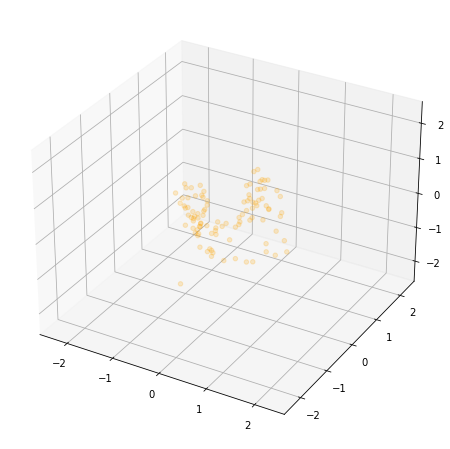

In [2]:
np.random.seed(69)
size, outliers_size = 100, 1
r, p = 1, 0.8
a, b = p*r, (1 - p)*r
t = np.random.uniform(0, 2*np.pi, size)

x_line = a*np.cos(t) + b*np.cos(3*t)
y_line = a*np.sin(t) - b*np.sin(3*t)
z_line = 2*np.sqrt(a*b)*np.sin(2*t)

true_points = np.stack([x_line, y_line, z_line]).T

# noise
noise = np.random.normal(scale=0.12*r, size=(size, 3))
noised_points = true_points + noise

outliers = np.random.normal(scale=1, size=(3, outliers_size))
outliers = 2 * outliers/np.linalg.norm(outliers, axis=0) #+ outliers_n
points = np.vstack([noised_points, outliers.T])
points = np.random.permutation(points)

t_curve = np.linspace(-np.pi, np.pi, 50)
x_curve = a*np.cos(t_curve) + b*np.cos(3*t_curve)
y_curve = a*np.sin(t_curve) - b*np.sin(3*t_curve)
z_curve = 2*np.sqrt(a*b)*np.sin(2*t_curve)

x, y, z = points.T

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, alpha=0.2, c='orange')

scale = 2.5
xmin, xmax, ymin, ymax, zmin, zmax = (-scale, scale)*3

ax.set_zlim3d(zmin,zmax)
ax.set_xlim3d(xmin,xmax)
ax.set_ylim3d(ymin,ymax)

In [3]:
def feature_map(X):
    q = np.einsum('ki,kj->kij',X,X)[(slice(None),) + np.triu_indices(X.shape[-1])]
    return np.hstack((q,X,np.ones((X.shape[0],1))))
def feature_map_q(X):
    return np.einsum('ki,kj->kij',X,X)[(slice(None),) + np.triu_indices(X.shape[-1])]
def projector_q(dim):
    return np.diag(np.hstack((np.ones(dim * (dim + 1) // 2), np.zeros(dim + 1))))

In [4]:
PhiX = feature_map(points)
cov = (PhiX).T.dot(PhiX)
w, v = linalg.eig(cov, b = projector_q(points.shape[1]))
coeffs = v[:,np.argsort(np.real(w))[:2]]

In [5]:
quadrics = Quadrics(n_quadrics=2, dist='dist0', device='gpu')
quadrics.fit(points, 500, learning_rate=0.1, batch_size=20)

Epoch  1
Orthonormal error: 0.0031857863068580627
Epoch  2
Orthonormal error: 0.0011070233304053545
Epoch  3
Orthonormal error: 0.00029555914807133377
Epoch  4
Orthonormal error: 0.00023013788450043648
Epoch  5
Orthonormal error: 0.0033041697461158037
Epoch  6
Orthonormal error: 0.0013145394623279572
Epoch  7
Orthonormal error: 0.0022974705789238214
Epoch  8
Orthonormal error: 0.006425897590816021
Epoch  9
Orthonormal error: 0.005370627157390118
Epoch  10
Orthonormal error: 0.00123952841386199
Epoch  11
Orthonormal error: 0.022873789072036743
Epoch  12
Orthonormal error: 0.0038929337169975042
Epoch  13
Orthonormal error: 0.003101061563938856
Epoch  14
Orthonormal error: 0.0007312499219551682
Epoch  15
Orthonormal error: 0.007289135362952948
Epoch  16
Orthonormal error: 0.007197519764304161
Epoch  17
Orthonormal error: 0.0016938515473157167
Epoch  18
Orthonormal error: 0.0016073398292064667
Epoch  19
Orthonormal error: 0.0019185430137440562
Epoch  20
Orthonormal error: 0.001103922724723

Orthonormal error: 0.007984064519405365
Epoch  173
Orthonormal error: 0.010389827191829681
Epoch  174
Orthonormal error: 0.005345391109585762
Epoch  175
Orthonormal error: 0.007242484949529171
Epoch  176
Orthonormal error: 0.003860199823975563
Epoch  177
Orthonormal error: 0.00380680407397449
Epoch  178
Orthonormal error: 0.006277880165725946
Epoch  179
Orthonormal error: 0.012224797159433365
Epoch  180
Orthonormal error: 0.005328740458935499
Epoch  181
Orthonormal error: 0.0030771999154239893
Epoch  182
Orthonormal error: 0.004742676857858896
Epoch  183
Orthonormal error: 0.00362229673191905
Epoch  184
Orthonormal error: 0.012535329908132553
Epoch  185
Orthonormal error: 0.004369129426777363
Epoch  186
Orthonormal error: 0.005094175226986408
Epoch  187
Orthonormal error: 0.004420230630785227
Epoch  188
Orthonormal error: 0.004125689622014761
Epoch  189
Orthonormal error: 0.0033961739391088486
Epoch  190
Orthonormal error: 0.008454126305878162
Epoch  191
Orthonormal error: 0.0065645277

Orthonormal error: 0.0033593513071537018
Epoch  341
Orthonormal error: 0.0019331523217260838
Epoch  342
Orthonormal error: 0.0056200590915977955
Epoch  343
Orthonormal error: 0.00553607614710927
Epoch  344
Orthonormal error: 0.00818233098834753
Epoch  345
Orthonormal error: 0.006345856003463268
Epoch  346
Orthonormal error: 0.001880014082416892
Epoch  347
Orthonormal error: 0.0018205984961241484
Epoch  348
Orthonormal error: 0.002631619106978178
Epoch  349
Orthonormal error: 0.004565056413412094
Epoch  350
Orthonormal error: 0.0036582322791218758
Epoch  351
Orthonormal error: 0.00986010953783989
Epoch  352
Orthonormal error: 0.003688535653054714
Epoch  353
Orthonormal error: 0.0030959344003349543
Epoch  354
Orthonormal error: 0.006060156039893627
Epoch  355
Orthonormal error: 0.006025815382599831
Epoch  356
Orthonormal error: 0.0033079793211072683
Epoch  357
Orthonormal error: 0.0024607544764876366
Epoch  358
Orthonormal error: 0.005290284752845764
Epoch  359
Orthonormal error: 0.00336

In [6]:
class GridSolver:
    
    def __init__(self, equations, grid, tolerance=1e-6):
        self.tolerance = tolerance
        self.grid = grid
        self.equations = equations
        self.solutions = set()
        
    def _add(self, solution):
        for sol in self.solutions:
            if (abs(sol[0] - solution[0]) + abs(sol[1] - solution[1])) < self.tolerance:
                return
        self.solutions.add(solution)
        
    def find(self):
        self.solutions = set()
        for p in self.grid:
            sol, d, eir, msg = fsolve(self.equations, p, full_output=True)
            if eir==1:
                self._add((sol[0], sol[1]))
        return self.solutions

In [7]:
def get_points_line(points, k=10):

    # eps = 1e-1

    blocks = []
    N = points.shape[0]
    neigh = NearestNeighbors(n_neighbors=k, metric='euclidean')
    neigh.fit(points)
    nearest = neigh.kneighbors(points, return_distance=False)

    first = 0
    second = nearest[first][1]
    next_point = [first, second]
    used = [second]
    while (len(used) < N):
        current = next_point[-1]
        new_points = [p for p in nearest[current] if p not in used]
        if len(new_points) > 0:
            next_point.append(new_points[0])
            used.append(new_points[0])
        else:
            new_points = [p for p in nearest[first] if p not in used]
            if len(new_points) > 0:
                next_point = next_point[::-1]
                next_point.append(new_points[0])
                used.append(new_points[0])
            else:
#                 used.append(first)
                blocks.append(points[next_point])
                new_block = [i for i in range(N) if i not in used]
                first = new_block[0]
                second = nearest[first][1]
                next_point = [first, second]
                used.append(second)

    blocks.append(points[next_point])

    return blocks

In [8]:
x = np.linspace(-2, 2, num=10)
y = np.linspace(-2, 2, num=10)
grid = np.array(np.meshgrid(x, y)).reshape((2, -1)).T
z = np.linspace(-4, 4, num=100)

q_points = []
for z_0 in tqdm(z):
    def equations(p):
        x, y = p
        p_0 = np.array([x, y, z_0])
        return quadrics.get_distances(p_0, dist='dist0')
    gs = GridSolver(equations, grid)
    sols = gs.find()
    for p in sols:
        x, y = p
        q_points.append((x, y, z_0))

quad_bloks = get_points_line(np.array(q_points))

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
def get_coeff_matrix(coeffs, ndim):
    quadratic = coeffs[:ndim*(ndim + 1)//2]
    linear = coeffs[ndim*(ndim + 1)//2:-1]
    free = coeffs[-1]
    M = np.zeros((ndim + 1, ndim + 1))
    M[np.triu_indices(3)] = quadratic
    M[np.tril_indices(3)] = M.T[np.tril_indices(3)]
    M[ndim, :ndim] = linear
    M[:ndim, ndim] = linear
    M[ndim, ndim] = free
    return M

def quadric_value(coeffs, point):
    point1 = np.append(point,1)  
    return point1.T.dot(coeffs.dot(point1))

In [10]:
x = np.linspace(-2, 2, num=10)
y = np.linspace(-2, 2, num=10)
grid = np.array(np.meshgrid(x, y)).reshape((2, -1)).T
z = np.linspace(-2, 2, num=100)

q_points = []
for z_0 in tqdm(z):
    def equations(p):
        x, y = p
        p_0 = np.array([x, y, z_0])
        #return quadrics.get_distances(p_0, dist='dist0')
        return [quadric_value(get_coeff_matrix(coeffs[:, 0], 3),p_0),quadric_value(get_coeff_matrix(coeffs[:, 1], 3),p_0)]
    gs = GridSolver(equations, grid)
    sols = gs.find()
    for p in sols:
        x, y = p
        q_points.append((x, y, z_0))
        
kpca_bloks = get_points_line(np.array(q_points))

  0%|          | 0/100 [00:00<?, ?it/s]

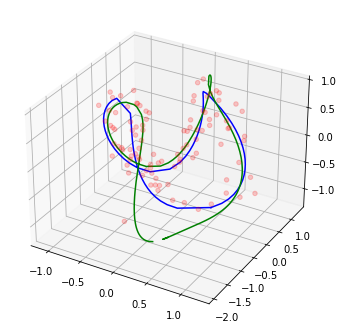

In [11]:
fig = plt.figure(figsize=(4, 4))
fig.subplots_adjust(left=-0.05, right=1.05, bottom=-0.5, top=1.5)
ax = fig.add_subplot(111, projection='3d')

x, y, z = points.T
ax.scatter(x, y, z, alpha=0.2, c='red')

# dist2 solution
for block in quad_bloks:
    ax.plot(block[:,0], block[:,1], block[:, 2], c = 'blue')
    
for block in kpca_bloks:
    ax.plot(block[:,0], block[:,1], block[:, 2], c = 'green')    